In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
input_file = "../../test_data/system_tests/MaxQuant_Kuster200/evidence.txt"
maxquant_file = "../../test_data/system_tests/MaxQuant_Kuster200/proteinGroups.txt"
directlfq_file = "../../test_data/system_tests/MaxQuant_Kuster200/evidence.txt.protein_intensities.tsv"

samplemap_directlfq = "../../test_data/system_tests/MaxQuant_Kuster200/samplemap.directLFQ.tsv"

samplemap_maxquant = "../../test_data/system_tests/MaxQuant_Kuster200/samplemap.maxLFQ.tsv"

run_directlfq = False

In [3]:
if run_directlfq:
    import directlfq.lfq_manager as lfqmgr

    lfqmgr.run_lfq(input_file=input_file, input_type_to_use="maxquant_evidence_benchmark", min_nonan=2)



In [4]:
import numpy as np

class VariationOverview():
    def __init__(self, name, quantified_data, protein_intensity_columns):
        self._protein_intensity_df = quantified_data[protein_intensity_columns]

        self.name = name
        self.quantified_proteins = None
        self._define_quantified_proteins()
    
    def _define_quantified_proteins(self):
        self.quantified_proteins = [QuantifiedProtein(x) for x in self._protein_intensity_df.to_numpy()]


class QuantifiedProtein():
    def __init__(self, intensities):
        intensities = np.where(intensities==0, np.nan, intensities) 
        self.intensities = intensities[np.isfinite(intensities)]
        self.cv = self._calc_cv()
    
    def _calc_cv(self):
        if len(self.intensities)<5:
            return np.nan
        return np.nanstd(self.intensities, ddof=1) / np.nanmean(self.intensities)





In [5]:
import matplotlib.pyplot as plt


class ProteinCVhistogram():
    def __init__(self, list_of_variation_overviews, ax: plt.Axes ):
        self._list_of_variation_overviews = list_of_variation_overviews
        self._ax = ax
        self._plot_histograms()

    def _plot_histograms(self):
        for variation_overview in self._list_of_variation_overviews:
            self._add_cv_histogram(variation_overview)
        
    def _add_cv_histogram(self, variation_overview):
        cvs = sorted([x.cv for x in variation_overview.quantified_proteins])
        all_cvs = len(cvs)
        cvs = [x for x in cvs if x<0.75]
        print(f"{all_cvs - len(cvs)} are very large for {variation_overview.name}")
        print(len(cvs))
        print(np.nanmean(cvs))
        print(np.nanmedian(cvs))
        self._ax.hist(cvs, label=variation_overview.name, cumulative=False, histtype='step', density=False, bins=150, linewidth = 1.5)
        


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_91958/1564291491.py:10: DtypeWarning: Columns (5,6,1624,1625,1626,1634,1635) have mixed types. Specify dtype option on import or set low_memory=False.
  results_df_maxquant = pd.read_csv(maxquant_file, sep = "\t")


22 are very large for directLFQ
3851
0.07624915732675706
0.06631551798133041
255 are very large for maxLFQ
3883
0.06711990925682737
0.05642579694854132


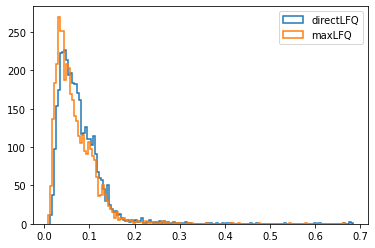

In [6]:
import directlfq.benchmarking as lfqbenchmark
import directlfq.utils as lfqutils
import pandas as pd

results_df_directlfq = pd.read_csv(directlfq_file, sep="\t")
relevant_columns_directlfq = [x for x in results_df_directlfq.columns if "Cycle" in x]
results_df_directlfq = results_df_directlfq[[";" not in x for x in results_df_directlfq['protein'].astype('str')]]
var_overview_directlfq = VariationOverview("directLFQ", quantified_data=results_df_directlfq, protein_intensity_columns=relevant_columns_directlfq)

results_df_maxquant = pd.read_csv(maxquant_file, sep = "\t")
results_df_maxquant = results_df_maxquant[[";" not in x for x in results_df_maxquant['id'].astype('str')]]
relevant_columns_maxquant = [x for x in results_df_maxquant.columns if "LFQ intensity " in x]
var_overview_maxquant = VariationOverview("maxLFQ", quantified_data=results_df_maxquant, protein_intensity_columns=relevant_columns_maxquant)

ax = plt.subplot()
ProteinCVhistogram([var_overview_directlfq, var_overview_maxquant], ax=ax)
ax.legend()
#
# ax.set_xlim(0, 0.5)
